In [ ]:
import numpy as np
import tensorflow as tf
import random as python_random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, InputLayer
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import random

# Seed reset function
def reset_random_seeds(seed_value=42):
    python_random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

reset_random_seeds()

# AES S-box and utility functions
AES_Sbox = [
    # S-box array
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
]

def Sbox(input_byte):
    return AES_Sbox[input_byte]

def HW(s):
    return bin(s).count("1")

AES_Sbox_inv = np.array([
    0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3, 0x9e, 0x81, 0xf3, 0xd7, 0xfb,
    0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f, 0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb,
    0x54, 0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b, 0x42, 0xfa, 0xc3, 0x4e,
    0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24, 0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25,
    0x72, 0xf8, 0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d, 0x65, 0xb6, 0x92,
    0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda, 0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84,
    0x90, 0xd8, 0xab, 0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3, 0x45, 0x06,
    0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1, 0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b,
    0x3a, 0x91, 0x11, 0x41, 0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6, 0x73,
    0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9, 0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e,
    0x47, 0xf1, 0x1a, 0x71, 0x1d, 0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b,
    0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0, 0xfe, 0x78, 0xcd, 0x5a, 0xf4,
    0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07, 0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f,
    0x60, 0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f, 0x93, 0xc9, 0x9c, 0xef,
    0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5, 0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2b, 0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0c, 0x7d
])

In [4]:
# Load the data
num_traces = 10000
trace_length = 5000
leakage = "ID"  # "HW" or "ID"
chipwhisper_folder = '/home/localuserplr/Documents/FYP/chipwhisperer/'

X = np.load(chipwhisper_folder + 'traces.npy')[:num_traces]
y = np.load(chipwhisper_folder + 'labels.npy')[:num_traces]
plaintexts = np.load(chipwhisper_folder + 'plain.npy')[:num_traces]
keys = np.load(chipwhisper_folder + 'key.npy')[:num_traces]

# Reshape X to match the input shape expected by Conv1D
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training+validation (80%) and attack (20%) sets
X_train_val, X_attack, y_train_val, y_attack, plaintexts_train_val, plaintexts_attack = train_test_split(
    X, y, plaintexts, test_size=0.2, random_state=42
)

# Split the training+validation data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Convert y_train and y_val to categorical
num_classes = 256  # Since you're using an 8-bit S-box, there are 256 possible output values
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_categorical = tf.keras.utils.to_categorical(y_val, num_classes)

# Define the model
model = Sequential()
model.add(InputLayer(input_shape=(trace_length, 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(256, activation='softmax'))  # Output layer for 8-bit S-box predictions

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary to verify the shapes
model.summary()

# Train the model with a reduced batch size to manage memory usage
history = model.fit(X_train, y_train_categorical, epochs=50, validation_data=(X_val, y_val_categorical), batch_size=32)

# Predictions on the attack set
predictions = model.predict(X_attack)
predicted_classes = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_classes == y_attack)
print(f"Attack set accuracy: {accuracy}")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 4998, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 2499, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 2497, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1248, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 79872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     5,111,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        16,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,134,848 (19.59 MB)

 Trainable params: 5,134,848 (19.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.0057 - loss: 5.5503 - val_accuracy: 0.0055 - val_loss: 5.5453
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 125ms/step - accuracy: 0.0051 - loss: 5.5418 - val_accuracy: 0.0035 - val_loss: 5.5457
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.0058 - loss: 5.5386 - val_accuracy: 0.0055 - val_loss: 5.5462
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.0054 - loss: 5.5358 - val_accuracy: 0.0055 - val_loss: 5.5462
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - accuracy: 0.0064 - loss: 5.5370 - val_accuracy: 0.0055 - val_loss: 5.5468
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.0064 - loss: 5.5356 - val_accuracy: 0.0055 - val_loss: 5.5474
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.0064 - loss: 5.5343 - val_accuracy: 0.0055 - val_loss: 5.5480
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - accuracy: 0.0064 - loss: 5

  0%|                                                   | 0/100 [00:00<?, ?it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 91  53  77 135 231  57 236  60  76 142 231 226 185  79  22  74]


  1%|▍                                          | 1/100 [00:00<00:22,  4.47it/s]

att_plt shape: (1000, 16)
att_plt sample: [137 161 208 127 161  12 198 246 116 188 243 152 109 215 240  65]


  2%|▊                                          | 2/100 [00:00<00:24,  4.03it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 29  15 161 173  87 160  11 133 218 119 222 205 226 255  26 121]


  4%|█▋                                         | 4/100 [00:00<00:21,  4.53it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 99 140 173 238 248 243 159   5  56  77 239  80 241 207 224 177]
att_plt shape: (1000, 16)
att_plt sample: [119  55 183  20 188 102 158 177 183  50 172  36  54  36 255 106]


  6%|██▌                                        | 6/100 [00:01<00:18,  5.12it/s]

att_plt shape: (1000, 16)
att_plt sample: [178 146 244 157  61 139 242   5 169   2   1 166   1   4 249  33]
att_plt shape: (1000, 16)
att_plt sample: [244  66  68  37 132 225 214 111  11  34 153 117 197  47 164  87]


  8%|███▍                                       | 8/100 [00:01<00:16,  5.51it/s]

att_plt shape: (1000, 16)
att_plt sample: [187 156  34  77 189 114   0  71 140   2  22 134  47 122 152  15]
att_plt shape: (1000, 16)
att_plt sample: [226 230 182  75 238  87 138 227 103 196  58 196 218 200  40 115]


 10%|████▏                                     | 10/100 [00:01<00:15,  5.66it/s]

att_plt shape: (1000, 16)
att_plt sample: [189 250 104 125 197 206   8  61 181 157  57 250 140 136   8 124]
att_plt shape: (1000, 16)
att_plt sample: [196 130 150  36  75  40  39 229 152 117 241 128 105 185 117 116]


 12%|█████                                     | 12/100 [00:02<00:15,  5.78it/s]

att_plt shape: (1000, 16)
att_plt sample: [140 206 103 141  40 164  53  90  10 161 225  38 129 165  56 182]
att_plt shape: (1000, 16)
att_plt sample: [ 94  22  84  98 125  28 122  85  80  50 155 141 171  53 239 159]


 14%|█████▉                                    | 14/100 [00:02<00:15,  5.60it/s]

att_plt shape: (1000, 16)
att_plt sample: [179 188 110  34  70  93 124  75 207 104 224 191 217 147  31 199]
att_plt shape: (1000, 16)
att_plt sample: [195   8  73  47 144 200 147  71  38 103  98 166 211 234 218 229]


 16%|██████▋                                   | 16/100 [00:03<00:14,  5.61it/s]

att_plt shape: (1000, 16)
att_plt sample: [234  31 229 250  63  20 249 119 115 194  11 179 148  10 169  58]
att_plt shape: (1000, 16)
att_plt sample: [ 16 118 219  41 182   0 191  11 141  86  20  28  85  67  22 123]


 18%|███████▌                                  | 18/100 [00:03<00:14,  5.73it/s]

att_plt shape: (1000, 16)
att_plt sample: [203 103 148  87 249  98 140 218 196  96 153 194  17 153 211 140]
att_plt shape: (1000, 16)
att_plt sample: [233 219  69 180 223  70   7   9 165  95  18 184 183  20 239  84]


 20%|████████▍                                 | 20/100 [00:03<00:13,  5.81it/s]

att_plt shape: (1000, 16)
att_plt sample: [232 167  57   5  73  68 228  24  79  40 195  55 248 249 242  38]
att_plt shape: (1000, 16)
att_plt sample: [161  15 237 166  79 125  84 227 100  66  22  21 133  81  61 123]


 22%|█████████▏                                | 22/100 [00:04<00:14,  5.55it/s]

att_plt shape: (1000, 16)
att_plt sample: [186 175  65 151  38  72 216 132  95 213   3 112 103 163 131 177]
att_plt shape: (1000, 16)
att_plt sample: [109 242  89 152 174 170 232  17  94 215 154 207  38 209  73   5]


 24%|██████████                                | 24/100 [00:04<00:13,  5.67it/s]

att_plt shape: (1000, 16)
att_plt sample: [158 142  95  25 104 235  95 163 107  47 196  10   3  39  12  44]
att_plt shape: (1000, 16)
att_plt sample: [ 71 189 232 222 229  58  98 248 255  45   5  26 206 180  25 245]


 26%|██████████▉                               | 26/100 [00:04<00:13,  5.33it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 36 135 214  37 114  62 236 149  80  89  65 236  87 234  63 200]
att_plt shape: (1000, 16)
att_plt sample: [  5 168  28  48  74  99 232 225  27 141  23  82 244 193  23 197]


 28%|███████████▊                              | 28/100 [00:05<00:12,  5.64it/s]

att_plt shape: (1000, 16)
att_plt sample: [215  82 191  39 158 145 227 169 184 253  58 110 167  14 106 136]
att_plt shape: (1000, 16)
att_plt sample: [101 214  96  94 164 191  50  69  88 240 104   8  29  94   0  69]


 30%|████████████▌                             | 30/100 [00:05<00:12,  5.77it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 72 186  55  61 153  24 146  60 150 125  83 221 151 151  59  27]
att_plt shape: (1000, 16)
att_plt sample: [126  60 182  15  92  10 101 100  64  84  45  99   6  35 209 189]


 32%|█████████████▍                            | 32/100 [00:05<00:11,  5.89it/s]

att_plt shape: (1000, 16)
att_plt sample: [152 243 207 102  81 121  78 151 215 148 107  33 197 204  15 244]
att_plt shape: (1000, 16)
att_plt sample: [228 174  33  87 211 171 162 176  18 175 110 173 152   4 133 180]


 34%|██████████████▎                           | 34/100 [00:06<00:11,  5.98it/s]

att_plt shape: (1000, 16)
att_plt sample: [208 135 223  88 223 116  21 173  12 126  68  38  36 246  37 189]
att_plt shape: (1000, 16)
att_plt sample: [ 10 184 129 182 224   6 114 208  55 135  80 221 229 102 251 231]


 36%|███████████████                           | 36/100 [00:06<00:10,  6.07it/s]

att_plt shape: (1000, 16)
att_plt sample: [233 219  69 180 223  70   7   9 165  95  18 184 183  20 239  84]
att_plt shape: (1000, 16)
att_plt sample: [ 39 136 160 228  17 157 238  32 170 209  91  31  41 180 155 101]


 38%|███████████████▉                          | 38/100 [00:06<00:10,  6.05it/s]

att_plt shape: (1000, 16)
att_plt sample: [235  96  72 234  79 215  21  43 247 192 196 185  11 205  48 247]
att_plt shape: (1000, 16)
att_plt sample: [145 102 255  52 110  43   1 189 178 118 155 190   0 233  73 215]


 40%|████████████████▊                         | 40/100 [00:07<00:09,  6.00it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 85 135  52 192  33  87  87  37 108 166  21  38 131 149 157 184]
att_plt shape: (1000, 16)
att_plt sample: [ 10  88  47 145   9  67  83 182 242 151 188 200 144  91 229  34]


 42%|█████████████████▋                        | 42/100 [00:07<00:09,  5.94it/s]

att_plt shape: (1000, 16)
att_plt sample: [101  43 166  22  37  61  37 242 198  21  54  79 197 116  35 153]
att_plt shape: (1000, 16)
att_plt sample: [ 36 135 214  37 114  62 236 149  80  89  65 236  87 234  63 200]


 44%|██████████████████▍                       | 44/100 [00:07<00:09,  5.72it/s]

att_plt shape: (1000, 16)
att_plt sample: [109 176  34  57 156 133 146 123 176  88 116  37 198  64  98  75]
att_plt shape: (1000, 16)
att_plt sample: [ 95 238  49 235  44 235 225 105 116  61 170  82  16 127 119  53]


 46%|███████████████████▎                      | 46/100 [00:08<00:09,  5.82it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 87  83 110  91  73  47 220  61 213 210  17  73 176 235  19  10]
att_plt shape: (1000, 16)
att_plt sample: [ 16  25 138  10 111  57 231  87 196 193 183  86  88 185 183  56]


 48%|████████████████████▏                     | 48/100 [00:08<00:08,  5.92it/s]

att_plt shape: (1000, 16)
att_plt sample: [215  55 236  89  95 114  11 244   9  80  25  68  75  71  27 170]
att_plt shape: (1000, 16)
att_plt sample: [  3  62  70  57  99 243  52 232 211 190  18  88 205 139 111 128]


 50%|█████████████████████                     | 50/100 [00:08<00:08,  5.98it/s]

att_plt shape: (1000, 16)
att_plt sample: [223 139  81 131 201 193 220  35   3  73 182  40 218 223  14 175]
att_plt shape: (1000, 16)
att_plt sample: [ 66 220 229  14 162 100  45   4 136  86 124 117  16  36 172 167]


 52%|█████████████████████▊                    | 52/100 [00:09<00:08,  5.96it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 85  70  30 161 227 163  93 183   6  73 185   9  29 194  51 224]
att_plt shape: (1000, 16)
att_plt sample: [224 244 156  35 152 218 212 108 125 197  78 106 194   0 196  13]


 54%|██████████████████████▋                   | 54/100 [00:09<00:07,  5.99it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 33  98  15 188 250 179 109 111 245 196 194  71 202  95  28  47]
att_plt shape: (1000, 16)
att_plt sample: [210 201 123  26  74  41 169 254 155 137  77 131  43  14  95 243]


 56%|███████████████████████▌                  | 56/100 [00:09<00:07,  5.80it/s]

att_plt shape: (1000, 16)
att_plt sample: [192 141 164 221 233  28 169 217 165  49 130 100  55  83  61 157]
att_plt shape: (1000, 16)
att_plt sample: [204  25 215 146  36 111 191  76 153  27 243 252 201  62 224 153]


 58%|████████████████████████▎                 | 58/100 [00:10<00:07,  5.79it/s]

att_plt shape: (1000, 16)
att_plt sample: [217  74 228  75  31 173  17 252 190  32 221 233  52  95 159 156]
att_plt shape: (1000, 16)
att_plt sample: [ 72  19  62 245  32 116  73 102  18 132 191  58  57  23 193  28]


 60%|█████████████████████████▏                | 60/100 [00:10<00:06,  5.96it/s]

att_plt shape: (1000, 16)
att_plt sample: [103 233 218  45  11  23  72 103  80  74 180  86 254  23 235 217]
att_plt shape: (1000, 16)
att_plt sample: [ 14  37  84 233  34  21 203 211 134 129 107  14 151 172 205  72]


 62%|██████████████████████████                | 62/100 [00:10<00:06,  6.03it/s]

att_plt shape: (1000, 16)
att_plt sample: [212  75 229 196 135 210  73 199 112 240  66  46 158 194  75  64]
att_plt shape: (1000, 16)
att_plt sample: [172 187   6 109 123 225  59  16  14  39 118  53 230 163 119  74]


 64%|██████████████████████████▉               | 64/100 [00:11<00:05,  6.04it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 46   6 189 207 139  89  61   0 170  41 157   3 122 185  73 153]
att_plt shape: (1000, 16)
att_plt sample: [143  18 248 135  39 249 183   6 249   6   9 197  98 122 116  22]


 66%|███████████████████████████▋              | 66/100 [00:11<00:05,  5.70it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 77  77 227 217 147  18 193 250 155 193  22 135  60 230  55 193]
att_plt shape: (1000, 16)
att_plt sample: [149 199  12   7  91 166  62 146 237 103   4 117 180 166 216 142]


 68%|████████████████████████████▌             | 68/100 [00:12<00:05,  5.46it/s]

att_plt shape: (1000, 16)
att_plt sample: [251  42 210 151  10 167 184  55  95 247  34 193  63 101  68 219]
att_plt shape: (1000, 16)
att_plt sample: [ 87  83 110  91  73  47 220  61 213 210  17  73 176 235  19  10]


 70%|█████████████████████████████▍            | 70/100 [00:12<00:05,  5.68it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 25 163 234  68 214 153  23  90  42 249  37 244  96 230  15  27]
att_plt shape: (1000, 16)
att_plt sample: [248  10   5 240 136 185 135  64 103 183 113 231 132 157  80  27]


 72%|██████████████████████████████▏           | 72/100 [00:12<00:04,  5.86it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 33 223 142  39 117  60  29  13   9 125 254  76  56  24 216  21]
att_plt shape: (1000, 16)
att_plt sample: [ 40   8 105 243 194 248 191  35 246  15 125  39  62 217  49  18]


 74%|███████████████████████████████           | 74/100 [00:13<00:04,  5.91it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 14  37  84 233  34  21 203 211 134 129 107  14 151 172 205  72]
att_plt shape: (1000, 16)
att_plt sample: [124 201 141 238 165 106  80  70 160  80  41 192 244  74  60 201]


 76%|███████████████████████████████▉          | 76/100 [00:13<00:04,  5.90it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 50 107 238 160 141 233  72  66 127   8 150 197 242 238  62   0]
att_plt shape: (1000, 16)
att_plt sample: [211 233 106  29 211 252 192  47 231 204  20 212 116  82  48 251]


 78%|████████████████████████████████▊         | 78/100 [00:13<00:03,  5.91it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 15 154 117 107 163 247 178 208 229 114 140  98  44 149  25 204]
att_plt shape: (1000, 16)
att_plt sample: [ 95 130  45 117  61 246  18 134 171 209 230 146  90 182  28 254]


 80%|█████████████████████████████████▌        | 80/100 [00:14<00:03,  5.97it/s]

att_plt shape: (1000, 16)
att_plt sample: [240 173  37 251 183  42  28 156 244 169  35 188 147 206 251  24]
att_plt shape: (1000, 16)
att_plt sample: [156 107 244 237 118 131  53 178 247 189  89 191 210  33  35 201]


 82%|██████████████████████████████████▍       | 82/100 [00:14<00:02,  6.03it/s]

att_plt shape: (1000, 16)
att_plt sample: [122  17 161 215 143 224  10  20 178 117 133 177   5  66 218  13]
att_plt shape: (1000, 16)
att_plt sample: [119  50  37  43 129 223  51  50  69 216 241 149 105  31  26 202]


 84%|███████████████████████████████████▎      | 84/100 [00:14<00:02,  5.71it/s]

att_plt shape: (1000, 16)
att_plt sample: [ 77  46  68  30 191 157 235  74 165 137 240 244 216 146 158 123]
att_plt shape: (1000, 16)
att_plt sample: [194 143  72 235  50  65  29  46 124 251  28 150 245  70 136   3]


 86%|████████████████████████████████████      | 86/100 [00:15<00:02,  5.83it/s]

att_plt shape: (1000, 16)
att_plt sample: [201 233 200 193 122  94 176 179 207  41 102 237  53 153 117 248]
att_plt shape: (1000, 16)
att_plt sample: [148 250 187 168  41 209 108 246 134  28 215 192 197 237  65 144]


 88%|████████████████████████████████████▉     | 88/100 [00:15<00:02,  5.75it/s]

att_plt shape: (1000, 16)
att_plt sample: [148  70 216 158  36 197 128 115  46 205 129  86   2  46 139 121]
att_plt shape: (1000, 16)
att_plt sample: [120  54 250  84 147  28 230   7 246   4  31  16 130 202  67 225]


 90%|█████████████████████████████████████▊    | 90/100 [00:15<00:01,  5.85it/s]

att_plt shape: (1000, 16)
att_plt sample: [235 226 253  78  54  85 131  52 166  29 159 163  93  48  58 175]
att_plt shape: (1000, 16)
att_plt sample: [171  70 175  45  40 139 249  90 235  10 170  14  33  20  71 129]


 92%|██████████████████████████████████████▋   | 92/100 [00:16<00:01,  5.83it/s]

att_plt shape: (1000, 16)
att_plt sample: [185 129 133  90  21 120 166 225 238 112 164 228   6 219 246 179]
att_plt shape: (1000, 16)
att_plt sample: [173  50 124  67 171 239  37 208 221 173  34  39  19 188  62 187]


 94%|███████████████████████████████████████▍  | 94/100 [00:16<00:01,  5.88it/s]

att_plt shape: (1000, 16)
att_plt sample: [140  73   8   9 243  32 221 226 207   4 100   6 233  56 189  86]
att_plt shape: (1000, 16)
att_plt sample: [173  95 172 206  99  57 184 252  27 130 181 151 216  14 168 151]


 96%|████████████████████████████████████████▎ | 96/100 [00:16<00:00,  5.89it/s]

att_plt shape: (1000, 16)
att_plt sample: [160 253  33 225 111  54  37 228  59  32  19 194 209 137 159   2]
att_plt shape: (1000, 16)
att_plt sample: [236 145 238 149 139 115  70 138 101 188 250  94  73 203  58  72]


 98%|█████████████████████████████████████████▏| 98/100 [00:17<00:00,  5.84it/s]

att_plt shape: (1000, 16)
att_plt sample: [  4  99 113  73 209 196 174 137  55  93 187 119 123 228  11 160]
att_plt shape: (1000, 16)
att_plt sample: [ 15  68 242  72 225 153  91 133 133 145  68  75  84 192 104  24]


100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.73it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


att_plt shape: (1000, 16)
att_plt sample: [ 56 239   7 241  11 123 134  54  56  10 204 216 144 200   9 149]
GE [120.3  122.96 120.42 124.01 118.9  115.16 116.12 114.28 113.22 116.41
 117.28 117.4  121.53 118.22 115.12 114.29 114.64 116.23 116.66 118.84
 120.15 118.96 118.28 118.86 119.91 120.77 122.55 122.15 120.63 118.96
 119.11 117.94 117.26 115.66 116.04 116.77 118.69 120.36 117.94 116.89
 115.96 117.65 119.57 119.63 118.96 119.1  120.53 118.57 120.09 119.25
 117.67 117.69 119.1  119.29 120.56 119.46 120.04 117.83 116.98 117.01
 115.09 115.   116.16 115.1  114.38 113.5  113.66 115.91 116.41 116.7
 115.67 115.91 117.99 117.52 118.09 117.31 116.9  116.57 116.46 116.18
 115.39 115.92 115.93 114.93 114.85 114.41 115.34 116.54 116.61 113.5
 112.77 111.17 109.87 110.4  110.   109.22 109.8  109.48 109.53 108.45
 108.33 106.73 108.   107.6  107.55 107.37 106.49 105.16 105.16 105.42
 104.1  104.21 104.85 105.7  104.95 104.13 104.7  104.46 104.71 104.43
 104.94 105.25 105.77 104.75 104.9  104

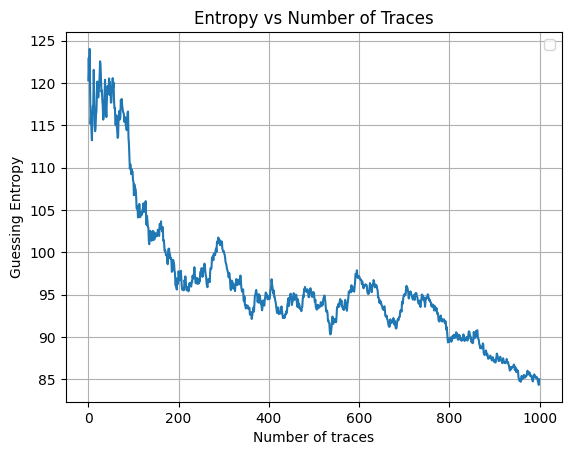

  0%|                                                   | 0/256 [00:00<?, ?it/s]/home/localuserplr/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/localuserplr/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████| 256/256 [01:41<00:00,  2.51it/s]


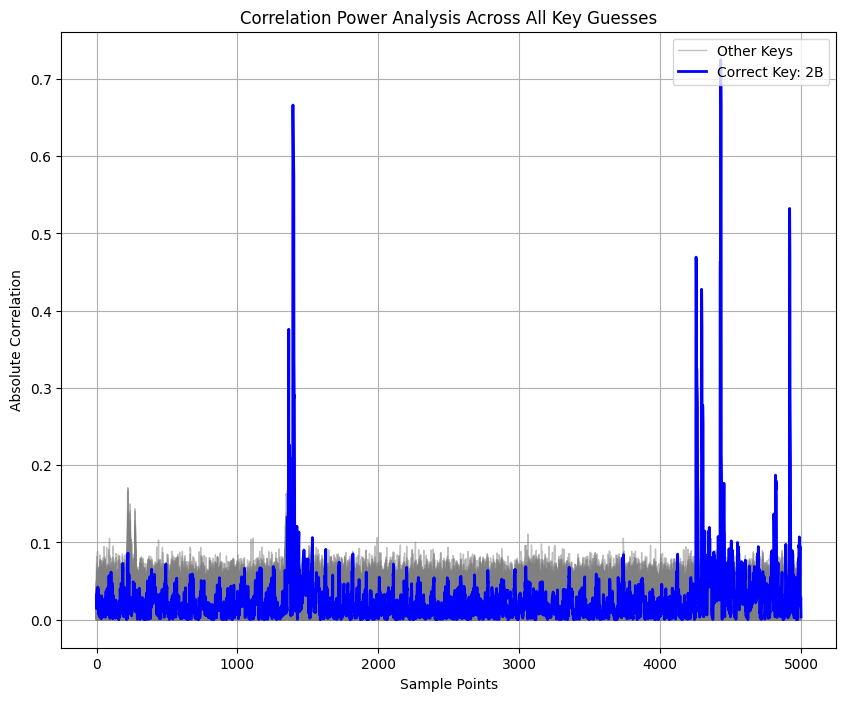

In [13]:
# Perform attacks and calculate Guessing Entropy (GE)
def perform_attacks(nb_traces=1000, predictions=predictions, plt_attack=plaintexts_attack, correct_key=None, leakage="HW", dataset=None, nb_attacks=100, shuffle=True):
    all_rk_evol = np.zeros((nb_attacks, nb_traces)) #(num_attack, num_traces used)
    all_key_log_prob = np.zeros(256)
    for i in tqdm(range(nb_attacks)):
        if shuffle:
            l = list(zip(predictions, plt_attack)) #list of [prediction, plaintext_attack]
            random.shuffle(l) #shuffle the each other prediction
            sp, splt = list(zip(*l)) #*l = unpacking, output: shuffled predictions and shuffled plaintext.
            sp = np.array(sp)
            splt = np.array(splt)
            att_pred = sp[:nb_traces] #just use the required number of traces
            att_plt = splt[:nb_traces]
        else:
            att_pred = predictions[:nb_traces]
            att_plt = plt_attack[:nb_traces]

        # Debugging information
        print("att_plt shape:", att_plt.shape)
        print("att_plt sample:", att_plt[0])

        rank_evol, key_log_prob = rank_compute(att_pred, att_plt, correct_key, leakage=leakage, dataset=dataset)
        all_rk_evol[i] = rank_evol
        all_key_log_prob += key_log_prob
    return np.mean(all_rk_evol, axis=0), key_log_prob

def rank_compute(prediction, att_plt, correct_key, leakage, dataset):
    hw = [bin(x).count("1") for x in range(256)]
    (nb_traces, nb_hyp) = prediction.shape
    key_log_prob = np.zeros(256)
    prediction = np.log(prediction + 1e-40)
    rank_evol = np.full(nb_traces, 255)
    for i in range(nb_traces):
        for k in range(256):
            att_byte = int(att_plt[i, 0])  # Use the first byte of the plaintext
            if dataset == "AES_HD_ext":
                if leakage == 'ID':
                    key_log_prob[k] += prediction[i, AES_Sbox_inv[k ^ att_byte] ^ att_byte]
                else:
                    key_log_prob[k] += prediction[i, hw[AES_Sbox_inv[k ^ att_byte] ^ att_byte]]
            elif dataset == "AES_HD_ext_ID":
                if leakage == 'ID':
                    key_log_prob[k] += prediction[i, AES_Sbox_inv[k ^ att_byte]]
                else:
                    key_log_prob[k] += prediction[i, hw[AES_Sbox_inv[k ^ att_byte]]]
            else:
                if leakage == 'ID':
                    key_log_prob[k] += prediction[i, AES_Sbox[k ^ att_byte]]
                else:
                    key_log_prob[k] += prediction[i, hw[AES_Sbox[k ^ att_byte]]]
        rank_evol[i] = rk_key(key_log_prob, correct_key)
    return rank_evol, key_log_prob

def rk_key(rank_array, key):
    key_val = rank_array[key]
    final_rank = np.float32(np.where(np.sort(rank_array)[::-1] == key_val)[0][0])
    if math.isnan(float(final_rank)) or math.isinf(float(final_rank)):
        return np.float32(256)
    else:
        return np.float32(final_rank)

def NTGE_fn(GE):
    # Start with infinity as the default
    NTGE = float('inf')
    # Iterate from the last index to the first
    for i in range(GE.shape[0] - 1, -1, -1):
        if GE[i] > 0:
            NTGE = i  # Set NTGE to the current index if condition is met
            break  # Exit the loop once condition is met
    return NTGE

nb_traces = 1000
GE, key_prob = perform_attacks(nb_traces, predictions=predictions, plt_attack=plaintexts_attack, correct_key=0x2B, leakage=leakage, dataset=None, nb_attacks=100, shuffle=True)
NTGE = NTGE_fn(GE)
print("GE", GE)
print("NTGE", NTGE)
plt.plot(GE)
plt.title('Entropy vs Number of Traces')
plt.xlabel('Number of traces')
plt.ylabel('Guessing Entropy')
plt.legend()
plt.grid(True)
plt.show()

# CPA Analysis and Plotting
def aes_label_cpa(plaintexts, correct_key, leakage):
    num_traces = plaintexts.shape[0]
    labels_for_snr = np.zeros(num_traces)
    for i in range(num_traces):
        if leakage == 'HW':
            labels_for_snr[i] = HW(AES_Sbox[plaintexts[i, 0] ^ correct_key])  # Use the first byte of the plaintext
        elif leakage == 'ID':
            labels_for_snr[i] = AES_Sbox[plaintexts[i, 0] ^ correct_key]  # Use the first byte of the plaintext
    return labels_for_snr

def perform_cpa_all_keys(traces, plaintexts, num_keys=256):
    num_traces, num_samples = traces.shape
    correlations = np.zeros((num_keys, num_samples))
    for key_guess in tqdm(range(num_keys)):
        labels_for_cpa = aes_label_cpa(plaintexts, key_guess, leakage)
        for t in range(num_samples):
            correlations[key_guess, t] = abs(np.corrcoef(labels_for_cpa[:num_traces], traces[:, t])[1, 0])
    return correlations

def plot_correlations(correlations, correct_key):
    num_keys, num_samples = correlations.shape
    plt.figure(figsize=(10, 8))
    for key_guess in range(num_keys):
        if key_guess != correct_key:
            plt.plot(correlations[key_guess], color='grey', label='Other Keys' if 'Other Keys' not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.5, linewidth=1)
    plt.plot(correlations[correct_key], color='blue', label=f'Correct Key: {correct_key:02X}', linewidth=2)
    plt.title('Correlation Power Analysis Across All Key Guesses')
    plt.xlabel('Sample Points')
    plt.ylabel('Absolute Correlation')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

# Perform CPA on the attack set
correlations = perform_cpa_all_keys(X_attack.squeeze(), plaintexts_attack, num_keys=256)
plot_correlations(correlations, correct_key=0x2B)